System information (for reproducibility):

In [1]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65e (2023-01-08 06:45 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 16 × AMD Ryzen 7 5800 8-Core Processor              
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, znver3)
  Threads: 8 on 16 virtual cores
Environment:
  JULIA_NUM_THREADS = 8


Load packages:

In [2]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `C:\Users\larry\Dropbox\zza\UCLA\academic\year 3\quarter 3\257\biostat-257-2023-spring\hw2`


Status `C:\Users\larry\Dropbox\zza\UCLA\academic\year 3\quarter 3\257\biostat-257-2023-spring\hw2\Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [052768ef] CUDA v4.1.4
  [7073ff75] IJulia v1.24.0
  [916415d5] Images v0.25.2
  [bdcacae8] LoopVectorization v0.12.157
  [91a5bcdd] Plots v1.38.10
  [a759f4b9] TimerOutputs v0.5.23
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [9abbd945] Profile


In [3]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

In [4]:
function nnmf(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,      
    niter   :: Number = 0,
    obj     :: Number = 0.0,
    obj_ref :: Number = 0.0,
    obj_dif :: Number = 0.0,
    trXtX   :: Number = 0.0,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    VtV     :: AbstractMatrix{T} = zeros(r, r),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    WWt     :: AbstractMatrix{T} = zeros(r, r),
    WWtVtV  :: AbstractMatrix{T} = zeros(r, r),
    WtVtX   :: AbstractMatrix{T} = zeros(size(X, 2), size(X, 2)),
    temp1   :: AbstractMatrix{T} = zeros(size(X, 1), r),
    temp2   :: AbstractMatrix{T} = zeros(size(X, 1), r),
    temp3   :: AbstractMatrix{T} = zeros(r, size(X, 2)),
    temp4   :: AbstractMatrix{T} = zeros(r, size(X, 2))
    ) where T <: AbstractFloat
    ni, nj = size(X)
    for n = 1:maxiter
        # V .= V .* (X * W') ./ (V * (W * W'))
        # W .= W .* (V' * X) ./ ((V' * V) * W)
        mul!(WWt, W, transpose(W))
        mul!(temp1, X, transpose(W))
        BLAS.symm!('R', 'U', 1.0, WWt, V, 0.0, temp2)       
        #V .= V .* temp1 ./ temp2
        for k = 1:r, i = 1:ni 
            V[i, k] = V[i, k] * temp1[i, k] / temp2[i, k]
        end
        mul!(VtV, transpose(V), V)
        mul!(temp3, transpose(V), X)        
        BLAS.symm!('L', 'U', 1.0, VtV, W, 0.0, temp4)
        #W .= W .* temp3 ./ temp4
        for j = 1:nj, k = 1:r 
            W[k, j] = W[k, j] * temp3[k, j] / temp4[k, j]
        end
        # obj = tr(X'X) - 2*tr(V'W'X) - tr(WW'V'V)
        mul!(WtVtX, transpose(W), temp3)
        BLAS.symm!('R', 'U', 1.0, WWt, VtV, 0.0, WWtVtV) 
        obj = trXtX - 2 * tr(WtVtX) + tr(WWtVtV)
        obj_dif = abs((obj - obj_ref) / (obj_ref + 1))
        if obj_dif < tolfun
            niter = n
            break
        else
            obj_ref = obj
            obj = 0
        end 
    end
    V, W, obj, niter
end

# test
r = 10
X = readdlm("nnmf-2429-by-361-face.txt")
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64)
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
trXtX = tr(transpose(X) * X)
V, W, obj, niter = nnmf(X, r, V = V0, W = W0, trXtX = trXtX)

([0.1185427580882575 0.03008722265556088 … 0.0029674312344360227 0.06410313800094321; 0.13178618807581147 0.0004450953636937514 … 0.015012233172060007 0.034971582898496806; … ; 0.05269290620030758 0.04799068122219491 … 0.1699414192313932 0.04613682375804976; 0.1293423739421669 0.019566216242175923 … 0.09442537068359769 0.02953788863458336], [4.31790935163119e-27 1.5112111776717967e-27 … 0.22996112327357018 2.424611083680001e-6; 0.011145748012727613 1.8372850717550925e-6 … 1.0455838868275476e-14 5.6690586912959135e-11; … ; 4.5661160009624637e-10 0.00012575667574452593 … 6.714908842631326e-6 1.4964819869563594e-12; 6.507865559907804e-10 7.945831213568098e-9 … 2.3489138494602314e-14 2.0385995785070035e-18], 11730.863965856814, 238)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

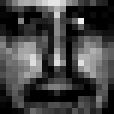

In [5]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

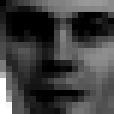

In [6]:
colorview(Gray, reshape(X[10, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

In [7]:
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    WWt = zeros(r, r)
    VtV = zeros(r, r)
    temp1 = zeros(ni, r)
    temp2 = zeros(ni, r)
    temp3 = zeros(r, nj)
    temp4 = zeros(r, nj)
    trXtX = tr(transpose(X) * X)
    WWtVtV = zeros(r, r)
    WtVtX = zeros(nj, nj)
    V, W, obj, niter = nnmf(X, r, V = V0, W = W0, trXtX = trXtX,
                            WWt = WWt, VtV = VtV, 
                            WWtVtV = WWtVtV, WtVtX = WtVtX,
                            temp1 = temp1, temp2 = temp2,
                            temp3 = temp3, temp4 = temp4)
    @btime nnmf($X, $r, V = $V0, W = $W0, trXtX = $trXtX,
                WWt = $WWt, VtV = $VtV, 
                WWtVtV = $WWtVtV, WtVtX = $WtVtX,
                temp1 = $temp1, temp2 = $temp2,
                temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!($V0, $V0full[:, 1 : r]), 
        copyto!($W0, $W0full[1 : r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  225.116 ms (2 allocations: 64 bytes)
obj=11730.863965856814, niter=238
r=20
  318.838 ms (2 allocations: 64 bytes)
obj=8497.602095402748, niter=393
r=30
  435.889 ms (2 allocations: 64 bytes)
obj=6621.946119263099, niter=481
r=40
  365.339 ms (2 allocations: 64 bytes)
obj=5256.86663720198, niter=580
r=50
  460.057 ms (2 allocations: 64 bytes)
obj=4430.362729032771, niter=697


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

In [8]:
Random.seed!(257)
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = Random.rand!(similar(X, size(X, 1), r))
    W0 = Random.rand!(similar(X, r, size(X, 2)))
    WWt = zeros(r, r)
    VtV = zeros(r, r)
    temp1 = zeros(ni, r)
    temp2 = zeros(ni, r)
    temp3 = zeros(r, nj)
    temp4 = zeros(r, nj)
    trXtX = tr(transpose(X) * X)
    WWtVtV = zeros(r, r)
    WtVtX = zeros(nj, nj)
    V, W, obj, niter = nnmf(X, r, V = V0, W = W0, trXtX = trXtX,
                            WWt = WWt, VtV = VtV, 
                            WWtVtV = WWtVtV, WtVtX = WtVtX,
                            temp1 = temp1, temp2 = temp2,
                            temp3 = temp3, temp4 = temp4)
    @btime nnmf($X, $r, V = $V0, W = $W0, trXtX = $trXtX,
                WWt = $WWt, VtV = $VtV, 
                WWtVtV = $WWtVtV, WtVtX = $WtVtX,
                temp1 = $temp1, temp2 = $temp2,
                temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!(V0, V0full[:, 1 : r]), 
        copyto!(W0, W0full[1 : r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  227.171 ms (2 allocations: 64 bytes)
obj=11665.326104662483, niter=224
r=20
  263.076 ms (2 allocations: 64 bytes)
obj=8418.875831428042, niter=308
r=30
  384.470 ms (2 allocations: 64 bytes)
obj=6621.5378999995155, niter=436
r=40
  351.105 ms (2 allocations: 64 bytes)
obj=5410.880959653368, niter=668
r=50
  357.408 ms (2 allocations: 64 bytes)
obj=4495.146736793904, niter=647


In this case, as r increases, the algorithm spent less time to converge. Nevertheless, the objective function values obtained show only slight differences.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

In [9]:
Random.seed!(257)
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = ones(ni, r)
    W0 = ones(r, nj)
    WWt = zeros(r, r)
    VtV = zeros(r, r)
    temp1 = zeros(ni, r)
    temp2 = zeros(ni, r)
    temp3 = zeros(r, nj)
    temp4 = zeros(r, nj)
    trXtX = tr(transpose(X) * X)
    WWtVtV = zeros(r, r)
    WtVtX = zeros(nj, nj)
    V, W, obj, niter = nnmf(X, r, V = V0, W = W0, trXtX = trXtX,
                            WWt = WWt, VtV = VtV, 
                            WWtVtV = WWtVtV, WtVtX = WtVtX,
                            temp1 = temp1, temp2 = temp2,
                            temp3 = temp3, temp4 = temp4)
    @btime nnmf($X, $r, V = $V0, W = $W0, trXtX = $trXtX,
                WWt = $WWt, VtV = $VtV, 
                WWtVtV = $WWtVtV, WtVtX = $WtVtX,
                temp1 = $temp1, temp2 = $temp2,
                temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!(V0, V0full[:, 1 : r]), 
        copyto!(W0, W0full[1 : r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  224.016 ms (2 allocations: 64 bytes)
obj=25297.01570593471, niter=4
r=20
  299.970 ms (2 allocations: 64 bytes)
obj=25297.015705934726, niter=4
r=30
  333.611 ms (2 allocations: 64 bytes)
obj=25297.015705934726, niter=4
r=40
  426.240 ms (2 allocations: 64 bytes)
obj=25297.0157059348, niter=4
r=50
  594.828 ms (2 allocations: 64 bytes)
obj=25297.01570593464, niter=4


In this case, we find that the algorithm converges within 4 iteration but spent longer time. In addition, the objective function value is much more higher than previously obtained results. This suggests that the convergence properties of NNMF algorithms can be sensitive to the choice of initialization, with no guarantee of always converging to a global minimum. At times, the algorithm may become trapped in a local minimum.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

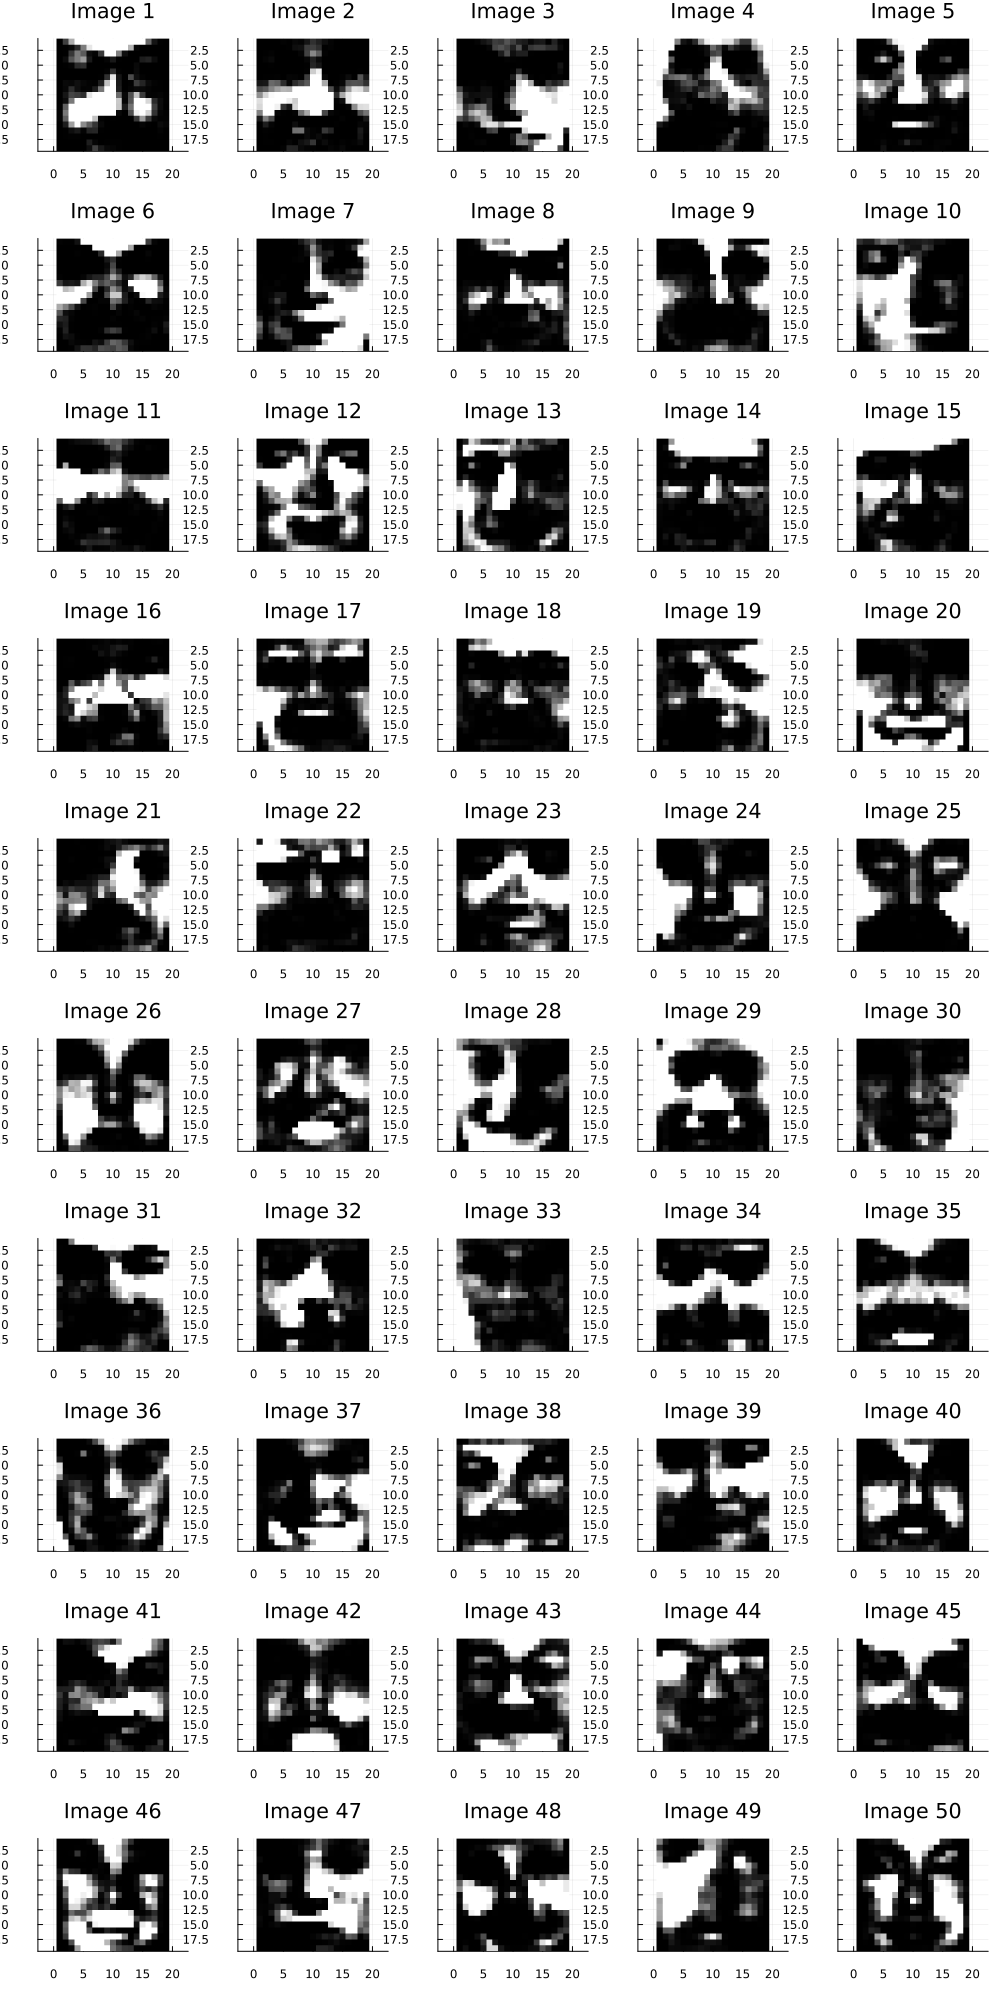

In [10]:
using Plots
Random.seed!(257)
V, W, obj, niter = nnmf(X, 50)
colorviews = [colorview(Gray, reshape(W[i, :], 19, 19)) for i in 1:50]
# Create a 10x5 grid layout for subplots
layout = grid(10, 5)
# Create an empty array to store the subplots
subplots = []

for (i, cv) in enumerate(colorviews)
    push!(subplots, heatmap(cv, title="Image $i", aspect_ratio=1))
end

plot(subplots..., layout=layout, size=(1000, 2000))

From the plots we can see that each row in W represents a feature or a pattern of the whole figure.

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

#### step 1: prepare package for GPU

In [11]:
using CUDA
CUDA.versioninfo()

CUDA runtime 12.1, artifact installation
CUDA driver 12.0
NVIDIA driver 528.24.0

Libraries: 
- CUBLAS: 12.1.0
- CURAND: 10.3.2
- CUFFT: 11.0.2
- CUSOLVER: 11.4.4
- CUSPARSE: 12.0.2
- CUPTI: 18.0.0
- NVML: 12.0.0+528.24

Toolchain:
- Julia: 1.8.5
- LLVM: 13.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0, 7.1, 7.2
- Device capability support: sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80, sm_86

1 device:
  0: NVIDIA GeForce RTX 3080 (sm_86, 8.431 GiB / 10.000 GiB available)


#### Step 2: prepare dataset stored in GPU

In [12]:
# generate SP data on CPU
r = 10
spx = convert(Matrix{Float32}, X)
spV0full = convert(Matrix{Float32}, V0full)
spW0full = convert(Matrix{Float32}, W0full)
cuspx = CuArray(spx)
CuV0 = CuArray(V0full[:, 1:r])
CuW0 = CuArray(W0full[1:r, :])

10×361 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 0.5634    0.32048   0.067202   0.25107   …  0.4476    0.12656   0.13688
 0.71473   0.25423   0.084735   0.84327      0.20947   0.32729   0.43787
 0.046351  0.041688  0.79152    0.8962       0.6786    0.17112   0.83691
 0.76991   0.13366   0.0061026  0.70588      0.4457    0.012722  0.64244
 0.56335   0.35408   0.62697    0.94923      0.073816  0.62934   0.58596
 0.13659   0.82449   0.17183    0.051802  …  0.87725   0.86247   0.45418
 0.2326    0.92296   0.73855    0.35246      0.015108  0.68424   0.15457
 0.95628   0.97221   0.94922    0.59106      0.49038   0.52232   0.4399
 0.82876   0.33257   0.95808    0.11028      0.66812   0.69979   0.57679
 0.33585   0.59454   0.75948    0.26544      0.34689   0.071471  0.020196

#### Step 3: prepare function for GPU

Here we revised function a little bit so that it can run smoothly in GPU:

1) avoid using `BLAS.symm!` since it is not recogonized.

2) avoid using some `for loop` since they are somehow very slow.

In [13]:
function nnmf_test(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,      
    niter   :: Number = 0,
    obj     :: Number = 0.0,
    obj_ref :: Number = 0.0,
    obj_dif :: Number = 0.0,
    trXtX   :: Number = 0.0,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    VtV     :: AbstractMatrix{T} = CUDA.zeros(r, r),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    WWt     :: AbstractMatrix{T} = CUDA.zeros(r, r),
    WWtVtV  :: AbstractMatrix{T} = CUDA.zeros(r, r),
    WtVtX   :: AbstractMatrix{T} = CUDA.zeros(size(X, 2), size(X, 2)),
    temp1   :: AbstractMatrix{T} = CUDA.zeros(size(X, 1), r),
    temp2   :: AbstractMatrix{T} = CUDA.zeros(size(X, 1), r),
    temp3   :: AbstractMatrix{T} = CUDA.zeros(r, size(X, 2)),
    temp4   :: AbstractMatrix{T} = CUDA.zeros(r, size(X, 2))
    ) where T <: AbstractFloat
    ni, nj = size(X)
    for n = 1:maxiter
        # V .= V .* (X * W') ./ (V * (W * W'))
        # W .= W .* (V' * X) ./ ((V' * V) * W)
        mul!(WWt, W, transpose(W))
        mul!(temp1, X, transpose(W))
        #BLAS.symm!('R', 'U', 1.0, WWt, V, 0.0, temp2)
        mul!(temp2, V, WWt)
        V .= V .* temp1 ./ temp2
        mul!(VtV, transpose(V), V)
        mul!(temp3, transpose(V), X)        
        #BLAS.symm!('L', 'U', 1.0, VtV, W, 0.0, temp4)
        mul!(temp4, VtV, W)
        W .= W .* temp3 ./ temp4
        # obj = tr(X'X) - 2*tr(V'W'X) - tr(WW'V'V)
        mul!(WtVtX, transpose(W), temp3)
        #BLAS.symm!('R', 'U', 1.0, WWt, VtV, 0.0, WWtVtV) 
        mul!(WWtVtV, WWt, VtV)
        obj = trXtX - 2 * tr(WtVtX) + tr(WWtVtV)
        obj_dif = abs((obj - obj_ref) / (obj_ref + 1))
        if obj_dif < tolfun
            niter = n
            break
        else
            obj_ref = obj
            obj = 0
        end 
    end
    V, W, obj, niter
end

nnmf_test (generic function with 1 method)

#### step 4: run and see results and speed

#### GPU (single precision data)

In [16]:
# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = CuArray(spV0full[:, 1:r])
    W0 = CuArray(spW0full[1:r, :])
    WWt = CUDA.zeros(r, r)
    VtV = CUDA.zeros(r, r)
    temp1 = CUDA.zeros(ni, r)
    temp2 = CUDA.zeros(ni, r)
    temp3 = CUDA.zeros(r, nj)
    temp4 = CUDA.zeros(r, nj)
    trXtX = tr(transpose(spx) * spx)
    WWtVtV = CUDA.zeros(r, r)
    WtVtX = CUDA.zeros(nj, nj)
    V, W, obj, niter = nnmf_test(cuspx, r, V = V0, W = W0, trXtX = trXtX,
                                 WWt = WWt, VtV = VtV, 
                                 WWtVtV = WWtVtV, WtVtX = WtVtX,
                                 temp1 = temp1, temp2 = temp2,
                                 temp3 = temp3, temp4 = temp4)
    CUDA.@sync @btime nnmf_test($cuspx, $r, V = $V0, W = $W0, trXtX = $trXtX,
                     WWt = $WWt, VtV = $VtV, 
                     WWtVtV = $WWtVtV, WtVtX = $WtVtX,
                     temp1 = $temp1, temp2 = $temp2,
                     temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!(V0, V0full[:, 1 : r]), 
        copyto!(W0, W0full[1 : r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  63.443 ms (90708 allocations: 4.20 MiB)
obj=11732.016, niter=237
r=20
  281.388 ms (382853 allocations: 17.71 MiB)
obj=8498.414, niter=392
r=30
  296.553 ms (382940 allocations: 17.72 MiB)
obj=6631.2812, niter=467
r=40
  282.658 ms (382694 allocations: 17.70 MiB)
obj=5260.0156, niter=574
r=50
  285.764 ms (382740 allocations: 17.71 MiB)
obj=4433.0156, niter=691


#### CPU (single precision data)

In [17]:
# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    ni, nj = size(X)
    V0 = spV0full[:, 1:r]
    W0 = spW0full[1:r, :]
    WWt = zeros(Float32, r, r)
    VtV = zeros(Float32, r, r)
    temp1 = zeros(Float32, ni, r)
    temp2 = zeros(Float32, ni, r)
    temp3 = zeros(Float32, r, nj)
    temp4 = zeros(Float32, r, nj)
    trXtX = tr(transpose(spx) * spx)
    WWtVtV = zeros(Float32, r, r)
    WtVtX = zeros(Float32, nj, nj)
    V, W, obj, niter = nnmf_test(spx, r, V = V0, W = W0, trXtX = trXtX,
                            WWt = WWt, VtV = VtV, 
                            WWtVtV = WWtVtV, WtVtX = WtVtX,
                            temp1 = temp1, temp2 = temp2,
                            temp3 = temp3, temp4 = temp4)
    @btime nnmf_test($spx, $r, V = $V0, W = $W0, trXtX = $trXtX,
                WWt = $WWt, VtV = $VtV, 
                WWtVtV = $WWtVtV, WtVtX = $WtVtX,
                temp1 = $temp1, temp2 = $temp2,
                temp3 = $temp3, temp4 = $temp4) setup=(
        copyto!(V0, V0full[:, 1 : r]), 
        copyto!(W0, W0full[1 : r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10
  144.854 ms (2 allocations: 64 bytes)
obj=11745.547, niter=226
r=20
  157.555 ms (1 allocation: 48 bytes)
obj=8532.578, niter=355
r=30
  224.606 ms (2 allocations: 64 bytes)
obj=6671.758, niter=412
r=40
  251.366 ms (2 allocations: 64 bytes)
obj=5292.117, niter=519
r=50
  353.386 ms (2 allocations: 64 bytes)
obj=4475.758, niter=605


#### Conclution

When comparing the summary tables for running time, we can observe that the GPU performs calculations faster than the CPU for smaller values of r (e.g., 10). However, as r increases (e.g., 40 ~ 50), the CPU and GPU provide similar running times. In terms of memory allocation, the GPU tends to allocate more memory during execution. Overall, the GPU achieves smaller objective function values than the CPU, indicating slightly better convergence for the algorith.